In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import statsmodels.api as sm
import statsmodels.tsa.api as smt
from statsmodels.tsa.stattools import adfuller

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from scipy.optimize import minimize

c:\Users\hp\anaconda3\Lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
file_names = [
'monthly-sales-of-company-x-jan-6.csv',
'monthly-boston-armed-robberies-j.csv',
'international-airline-passengers.csv',
'mean-monthly-air-temperature-deg.csv',
'weekly-closings-of-the-dowjones-.csv',
'daily-total-female-births-in-cal.csv'
]

In [3]:
for file_name in file_names:
    ds = pd.read_csv(file_name).iloc[:,-1]
    print( file_name, f'pvalue: {adfuller( ds )[1]:,.1%}' )

monthly-sales-of-company-x-jan-6.csv pvalue: 98.9%
monthly-boston-armed-robberies-j.csv pvalue: 99.4%
international-airline-passengers.csv pvalue: 99.2%
mean-monthly-air-temperature-deg.csv pvalue: 1.7%
weekly-closings-of-the-dowjones-.csv pvalue: 62.2%
daily-total-female-births-in-cal.csv pvalue: 0.0%


In [4]:
ds_1 = pd.read_csv( file_names[0] ).iloc[:,-1]
ds_2 = pd.read_csv( file_names[-1] ).iloc[:,-1]

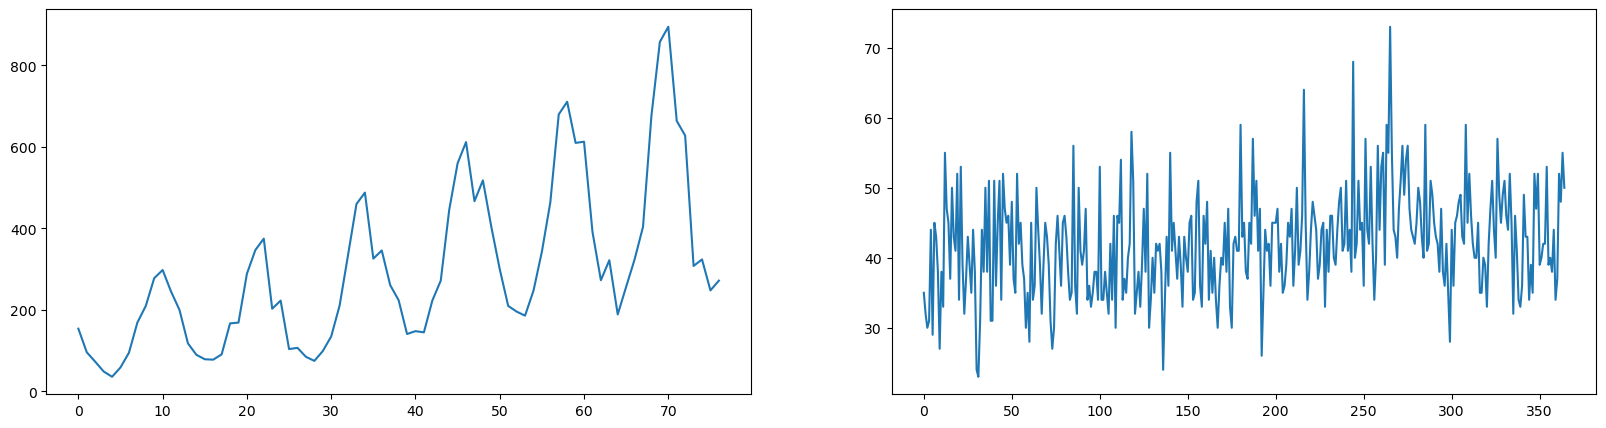

In [5]:
fig, ax = plt.subplots(1,2, figsize=(20,5))
ds_1.plot( ax=ax[0] )
ds_2.plot( ax=ax[1] )
plt.show();

Для стационарного ряда выбираем простое скользящее среднее, 

но т.к. тренда в нём нет совсем - то прогноз сводится к воспроизведению похожего шума,

несильно отклоняясь от вариации значения.

В данном случае тренд немножко усложнился - чтобы холмики в районе 50 и 250-300 можно было учесть.

Вообще - прогноз такого графика лучше в виде коридора смотреть, или свечей,

потому что визуально реалистичным будет любой прогноз, похожий на один из кусочков предыдущего.

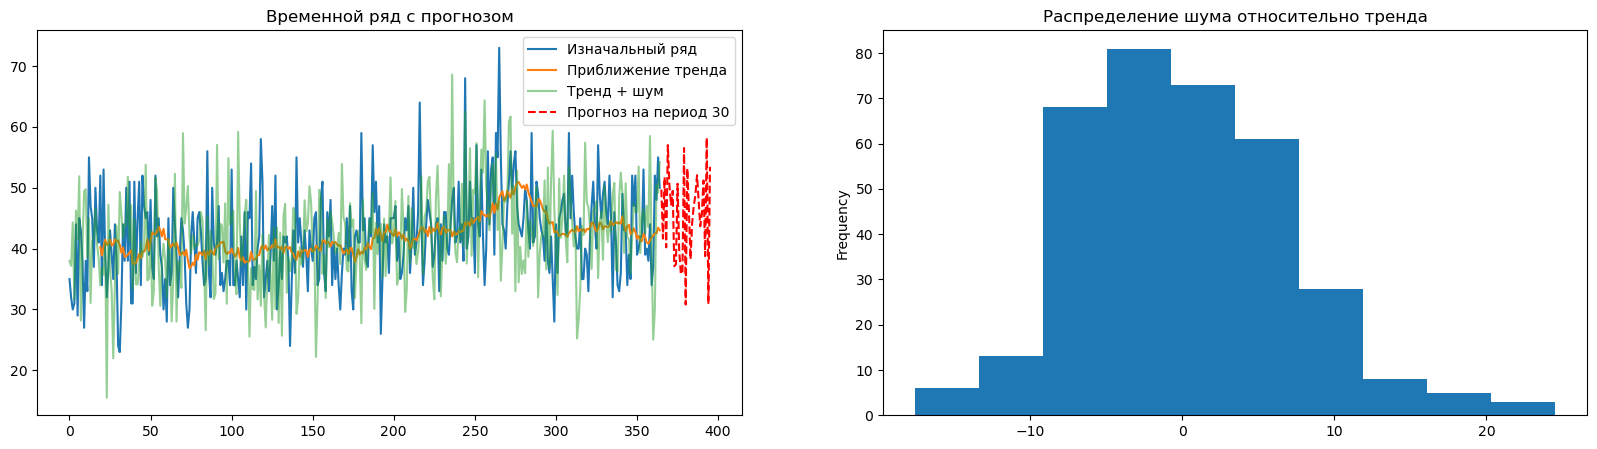

In [6]:
predict_period = 30

# Основной тренд - как среднее скользящее за 20
# И, т.к. график стационарный и хаотичный -
# веса определеляются случайно через выбро с повторениями
ds_2_1 = ds.rolling(20).apply( lambda x: ( np.mean( x.sample( n=200, replace=True ) ) ) )

# Оценка шума
deltas = ( ( ds_2 - ds_2_1 ).dropna() )
d_mean = np.mean( deltas )
d_std = np.std( deltas ) 

def add_noise(d_mean, d_std, size):
    y = np.random.normal( d_mean, d_std, size=size )
    return pd.Series( y ).reset_index(drop=True)


predict_n = 20+predict_period

# К полученному тренду добавляются шум и прогноз, через случайную выборку
ds_2_2 = pd.concat([
     ds_2_1
     + add_noise( d_mean, d_std, ds_2_1.shape[0] ),

     ds_2_1[-100:].sample(predict_n, replace=True).reset_index(drop=True)
     + add_noise( d_mean, d_std, predict_n )

]).dropna().reset_index( drop=True )



fig, ax = plt.subplots(1,2, figsize=(20,5) )
ds_2.plot( ax=ax[0] )
ds_2_1.plot( ax=ax[0] )

ds_2_2[ds_2.index].plot( alpha=0.5, ax=ax[0] )
ds_2_2[ds_2.index[-1]+1:].plot( color='red', style='--', ax=ax[0] )

ax[0].legend(['Изначальный ряд','Приближение тренда','Тренд + шум',f'Прогноз на период {predict_period}'])
ax[0].set_title('Временной ряд с прогнозом')

deltas.plot.hist( ax=ax[1], title='Распределение шума относительно тренда' )

plt.show();

Данные с прогнозом слабо коррелированны,

т.е. прогноз точь-в-точь данные не повторяет.

<Axes: xlabel='data_serie', ylabel='predicting'>

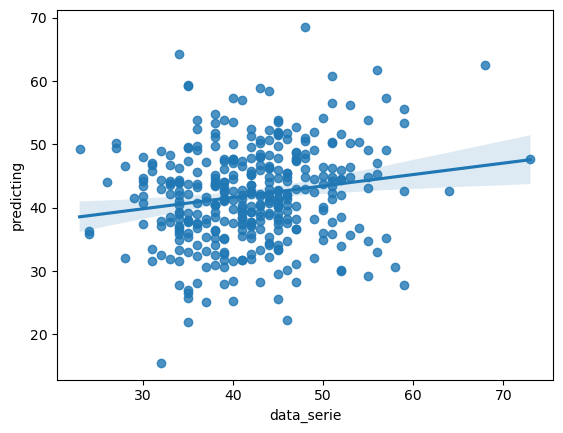

In [7]:
inds = ( ds_2_2 * ds_2 ).dropna().index
d = pd.DataFrame([ds_2[inds], ds_2_2[inds]], index=['data_serie','predicting']).T
sns.regplot( d, x='data_serie', y='predicting' )

Средняя квадратичная ошибка день-в-день высокая - 200% от среднего.

Если посмотреть через скользящую среднюю - то ошибка снижается.

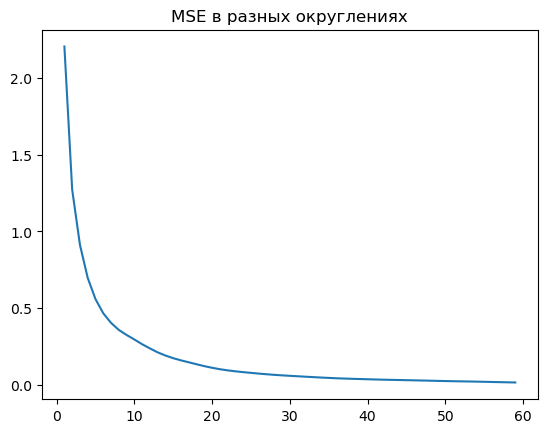

In [8]:
mse = [] 

for i in range(1,60):
    mse_cur = mean_squared_error( ds_2[inds].rolling(i).mean().dropna(), ds_2_2[inds].rolling(i).mean().dropna() ) / ds_2[inds].mean()
    mse.append( mse_cur )

plt.plot( range(1,60), mse )
plt.title('MSE в разных округлениях')
plt.show();

In [9]:
mae = mean_absolute_error( ds_2[inds], ds_2_2[inds] ) / ds_2[inds].mean()
var = ds_2[inds].std() / ds_2[inds].mean()
print(f' mae: {mae:.2%}, var: {var:.2%}, mae/var: {mae / var:.2%} ')

 mae: 17.86%, var: 17.50%, mae/var: 102.02% 


Для ряда с сезонностью применяется метод Хольта-Винтерса

В виде класса, чтобы меньше с переменными путаться

In [ ]:
class HoltWintersPredict:
    def __init__(self, data, season_len):
        self.data = data #Временной ряд
        self.season_len = season_len #Длина сезона
        self.n_data = len(self.data) #Значений в исходном временном ряде
        self.n_seasons = int(  self.n_data/self.season_len ) #Количество сезонов
        self.season_averages = [] #Средние в циклах сезонов
        self.seasonals = {} #Сезонность
        self.result = [] #Результат прогноза
        self.alpha = 0 #
        self.beta = 0 #
        self.gamma = 0 #

    def initial_trend(self):
        ''' Вычисляется тренд '''
        series_sum = sum([ 
            float(self.data[i+self.season_len]
                  - self.data[i])
             / self.season_len 
                   for i 
                   in self.data.index[:-self.season_len] ])
        self.trend = series_sum / self.season_len

    def initial_seasonal_components(self):
        ''' Вычисляется сезонность '''
        # Среднее для каждого цикла
        for j in range( self.n_seasons ):
            season_start = self.season_len*j
            season_sum = sum( self.data[ season_start:season_start+self.season_len  ] )
            season_average = season_sum / float(self.season_len)
            self.season_averages.append( season_average )

        # сеозонность
        for i in range(self.season_len):
            sum_of_vals_over_avg = 0.0
            for j in range( self.n_seasons ):
                season_start = self.season_len*j
                sum_of_vals_over_avg += self.data[ season_start+i ] - self.season_averages[j]
            self.seasonals[i] = sum_of_vals_over_avg / self.n_seasons

    def triple_exponential_smoothing(self, alpha, beta, gamma, n_preds):
        ''' Прогноз по тройному экспоненциальному сглаживанию '''
        self.alpha = alpha
        self.beta = beta 
        self.gamma = gamma
        self.result = []

        # Цикл - количество данных + период прогнозирования
        for i in range( self.n_data + n_preds ):
            # В начале цикла добавляем первое реальное значение
            if i == 0:
                smooth = self.data[0]
                self.result.append( smooth )
                continue

            # Если ещё этап повторения данных,
            # то строим следующее значение
            season_step = i%self.season_len #Шаг сезонности
            if i < self.n_data:
                val = self.data[i]
                # Комбинация роста по тренду и текущего значения без сезонности = (1-альфа)*(предудущее значение + тренд) + (альфа)*(текущее значение - колебание сезонности)
                last_smooth, smooth = smooth, (1-alpha)*(smooth+self.trend) + alpha*(val-self.seasonals[season_step])
                # Сглаженный тренд = (1-бета)*(тренд) + (бета)*(сглаженное - предыдущее сглаженное)
                trend = (1-beta)*self.trend + beta*( smooth-last_smooth )
                # Сезонность корректируется на разницу текущего к сглаженному = (1-гамма)*(сеозонность) + (гамма)*(текущее значение - сглаженное)
                self.seasonals[season_step] = (1-gamma)*self.seasonals[season_step] + gamma*( val-smooth )

                # Сглаженное + сглаженный тренд + сезонность
                self.result.append( 
                    smooth
                    +trend
                    +self.seasonals[season_step] 
                    )            

            # Если этап прогнозирования - то накопленные показатели просто используются
            else:
                # Шаг прогнозирования - от 0
                m = i + 1 - self.n_data
                # Сглаженное + тренд за количество дней прогноза + корректировка на сезонность
                self.result.append(  
#1                  #smooth + ( 1+m//self.season_len )*trend + self.seasonals[season_step]
                    smooth + m*trend + self.seasonals[season_step]
                )


                
        self.result = pd.Series( self.result )
        # Устранение небольшого смещения
        mn = np.mean( self.result[ :self.n_data ] - self.data[ :self.n_data ] )
        self.result = self.result - mn


    def fit(self):
        ''' Предрасчёт для прогнозирования '''
        self.initial_trend()
        self.initial_seasonal_components()

    def optimize(self):
        ''' Оптимизация параметров тройного экспоненциального сглаживания'''
        # для тестирования отрезается по 1 сезонному циклу
        train, test, val = self.data[:-2*self.season_len], self.data[-2*self.season_len:-1*self.season_len], self.data[-1*self.season_len:]

        def mse(X):
            alpha, beta, gamma = X 
            self.triple_exponential_smoothing( alpha, beta, gamma, len(test) )
            predictions = self.result[-len(test):]
            error = mean_squared_error( predictions, test )
            return error

        bounds = ((.0,1.0),(.0,1.0),(.0,1.0))
        x0 = [bound[0] for bound in bounds]
        opt = minimize( mse, x0=x0, method='L-BFGS-B', bounds=bounds )
        print(opt.success)
        self.alpha = opt.x[0]
        self.beta = opt.x[1]
        self.gamma = opt.x[2]

    def plot(self):
        ''' Рисунок данных и тестовых '''
        plt.figure(figsize=(20,5))
        plt.plot(self.data, color='blue', label='original')
        plt.plot(self.result, color='red', linewidth='4', alpha=0.5, label='tirple_exponential_smoothing')

        self.mse = mean_squared_error( self.result[:self.n_data], self.data[:self.n_data] )
        self.r2 = r2_score( self.result[:self.n_data], self.data[:self.n_data] )
        plt.title(f'''RMSE: {self.mse:.2f}, R2: {self.r2:.2%}
alpha={self.alpha:.1%} beta={self.beta:.1%} gamma={self.gamma:.1%}''')
        plt.legend()

    def plot_seasonality(self):
        ''' Рисунок сезонности '''
        pd.DataFrame.from_dict( self.seasonals, orient='index', columns=['Сезонность'] ).plot();
        plt.axhline(y=0, linestyle='--', color='green')

    def predict_plot(self, alpha, beta, gamma, n_preds):
        ''' Прогноз с рисунком '''
        self.triple_exponential_smoothing(alpha, beta, gamma, n_preds)
        self.plot()

    def predict_plot_optimize(self, n_preds):
        ''' Прогноз после оптимизаии с рисунком '''
        self.optimize()
        self.triple_exponential_smoothing(self.alpha, self.beta, self.gamma, n_preds)
        self.plot()

In [17]:
hwp = HoltWintersPredict(ds_1, 12)
hwp.fit()
#vars( hwp )

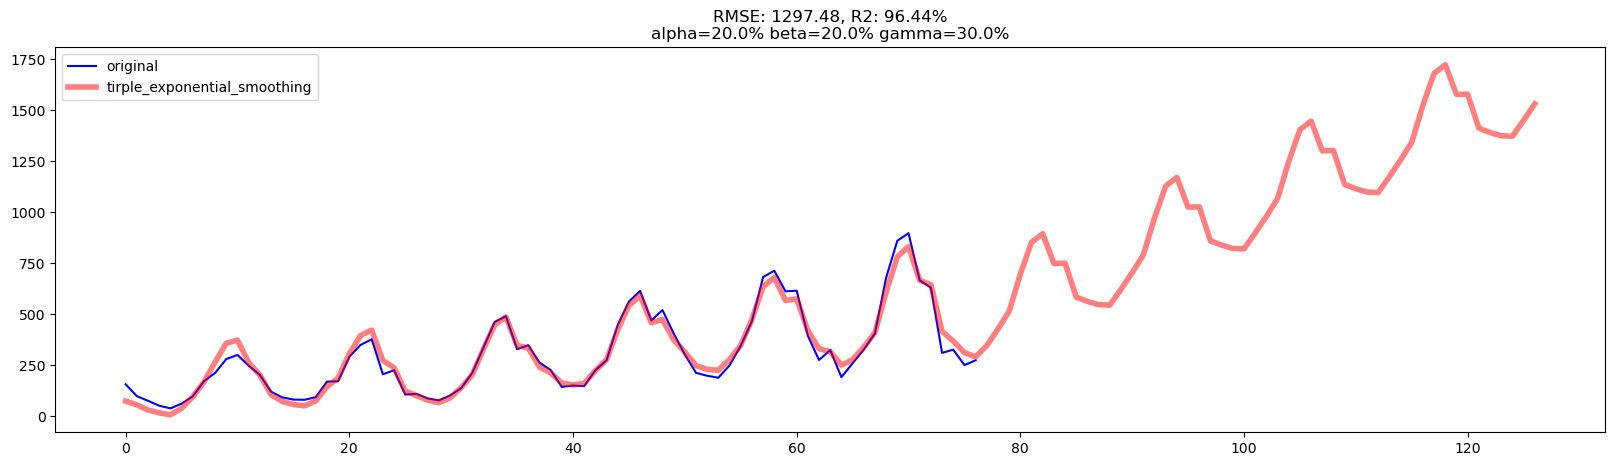

In [18]:
hwp.triple_exponential_smoothing(0.2,0.2,0.3, 50)
hwp.plot()

True


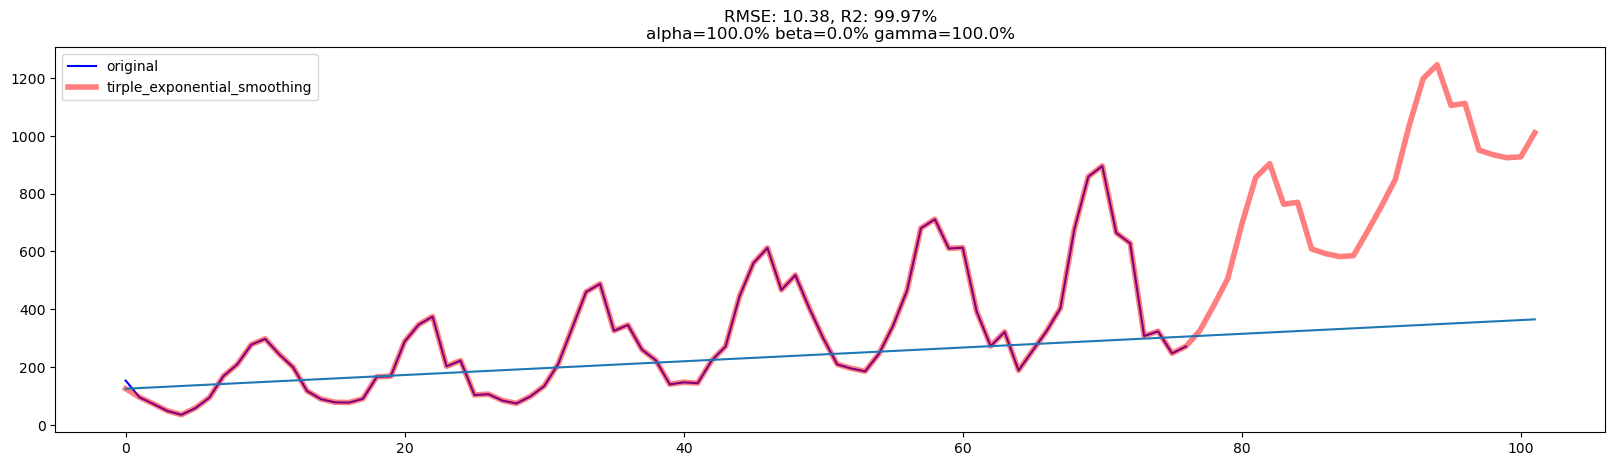

In [19]:
hwp.predict_plot_optimize(25)
plt.plot( [hwp.result[0]+i/hwp.season_len*hwp.trend for i in hwp.result.index], label='Изначальный тренд' )